In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.animation as animation
print(mpl.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from time import time
import uproot4 as up
from scipy.signal import find_peaks as fp
from scipy.fft import fft, ifft, fftfreq, fftshift
import scipy.signal as signal
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
tamm = 20
plt.rcParams["font.size"] = tamm
plt.rc('axes', titlesize=tamm, labelsize=tamm)
plt.rc('xtick',labelsize=tamm)
plt.rc('ytick',labelsize=tamm)
xt = np.arange(0.5, 512., 1)
import os
from lmfit.models import GaussianModel
plt.rcParams['animation.ffmpeg_path'] =r'C:\Users\guilh\Documents\ffmpeg-4.4-full_build\ffmpeg-4.4-full_build\bin\ffmpeg.exe'

3.5.2


# Carregamento de dados

In [2]:
def load_data_700():
    ti  = time()
    # f = up.open("/content/drive/MyDrive/Collabs/tspec_out_192_3.root")
    f = up.open("./dados/tspec_out_224_700.root")
    branches      = f[f.keys()[0]].arrays(library = "np")
    inputt        = [] # branches["input"].reshape(len(branches["input"]), 511)
    target1       = []
    target2       = [] # branches["target"].reshape(len(branches["input"]), 511)
    peaks         = []
    BKG           = []
    # scaled_deconv = []
    for i in range(len(branches["input"])):
        inputt.append(branches["input"][i].reshape(-1))
        target1.append(branches["inputBK"][i].reshape(-1))
        target2.append(branches["target"][i].reshape(-1))
        BKG.append(branches["fundo"][i].reshape(-1))
        peaks.append(branches["peaks"][i].astype(float).round().astype(int).reshape(-1))
    # scaled_deconv.append(branches["deconv_scale"][i].reshape(-1))
    inputt         = np.array(inputt, dtype = float)
    target1       = np.array(target1, dtype = float)
    target2       = np.array(target2, dtype = float)
    BKG           = np.array(BKG, dtype = float)
    peaks         = np.array(peaks, dtype = object)
    # scaled_deconv = np.array(scaled_deconv, dtype = float)
    f.close()
    print("Tempo para carregar dados = %.3fs"%(time() - ti))
    return inputt, target1, target2, peaks, BKG, target2*0.85

def load_data_BKGs():
    ti  = time()
    # f = up.open("/content/drive/MyDrive/Collabs/tspec_out_192_3.root")
    f  = up.open("./dados/tspec_out_224_700.root")
    f2 = up.open("./dados/signal_data.root")
    branches      = f[f.keys()[0]].arrays(library = "np")
    branches2     = f2[f2.keys()[0]].arrays(library = "np")
    inputt        = [] # branches["input"].reshape(len(branches["input"]), 511)
    target1       = []
    target2       = [] # branches["target"].reshape(len(branches["input"]), 511)
    peaks         = []
    BKG           = []
    # scaled_deconv = []
    for i in [1, 13]:
        inputt.append(branches["input"][i].reshape(-1))
        target1.append(branches["inputBK"][i].reshape(-1))
        target2.append(branches["target"][i].reshape(-1))
        BKG.append(branches["fundo"][i].reshape(-1))
        peaks.append(branches["peaks"][i].astype(float).round().astype(int).reshape(-1))
        # scaled_deconv.append(branches["deconv_scale"][i].reshape(-1))
    for i in [26, 65]:
        inputt.append(branches2["input"][i].reshape(-1))
        target1.append(branches2["input_sem_fundo"][i].reshape(-1))
        target2.append(branches2["deconv"][i].reshape(-1))
        BKG.append(branches2["fundo"][i].reshape(-1))
        peaks.append(branches2["picos"][i].astype(float).round().astype(int).reshape(-1))
        # scaled_deconv.append(branches["deconv_scale"][i].reshape(-1))
    inputt        = np.array(inputt, dtype = float)
    target1       = np.array(target1, dtype = float)
    target2       = np.array(target2, dtype = float)
    BKG           = np.array(BKG, dtype = float)
    peaks         = np.array(peaks, dtype = object)
  # scaled_deconv = np.array(scaled_deconv, dtype = float)
    f.close()
    print("Tempo para carregar dados = %.3fs"%(time() - ti))
    return inputt, target1, target2, peaks, BKG, target2*0.85

def load_data_DECONVs():
    ti  = time()
    # f = up.open("/content/drive/MyDrive/Collabs/tspec_out_192_3.root")
    f  = up.open("./dados/tspec_out_224_700.root")
    branches      = f[f.keys()[0]].arrays(library = "np")
    inputt        = [] # branches["input"].reshape(len(branches["input"]), 511)
    target1       = []
    target2       = [] # branches["target"].reshape(len(branches["input"]), 511)
    peaks         = []
    BKG           = []
    # scaled_deconv = []
    for i in [0, 2, 143, 148]:
        inputt.append(branches["input"][i].reshape(-1))
        target1.append(branches["inputBK"][i].reshape(-1))
        target2.append(branches["target"][i].reshape(-1))
        BKG.append(branches["fundo"][i].reshape(-1))
        peaks.append(branches["peaks"][i].astype(float).round().astype(int).reshape(-1))
        # scaled_deconv.append(branches["deconv_scale"][i].reshape(-1))
    inputt        = np.array(inputt, dtype = float)
    target1       = np.array(target1, dtype = float)
    target2       = np.array(target2, dtype = float)
    BKG           = np.array(BKG, dtype = float)
    peaks         = np.array(peaks, dtype = object)
  # scaled_deconv = np.array(scaled_deconv, dtype = float)
    f.close()
    print("Tempo para carregar dados = %.3fs"%(time() - ti))
    return inputt, target1, target2, peaks, BKG, target2*0.85

def load_data_700_attpc():
    # Na verdade foram 200 it com sigma = 5.
    ti  = time()
    # f = up.open("/content/drive/MyDrive/Collabs/tspec_out_192_3.root")
    f = up.open("./dados/signal_data.root")
    branches      = f[f.keys()[0]].arrays(library = "np")
    input         = [] # branches["input"].reshape(len(branches["input"]), 511)
    fundos        = []
    input_wo_bkg  = [] # branches["target"].reshape(len(branches["input"]), 511)
    deconv        = []
    BKG           = []
    peaks         = []
    # scaled_deconv = []
    pads = np.zeros(200_000, dtype = int)
    # for i in range(len(branches["input"])):
    for i in range(200_000):
        input.append(branches["input"][i].reshape(-1))
        fundos.append(branches["fundo"][i].reshape(-1))
        input_wo_bkg.append(branches["input_sem_fundo"][i].reshape(-1))
        deconv.append(branches["deconv"][i].reshape(-1))
        peaks.append(branches["picos"][i].astype(float).round().astype(int).reshape(-1))
        pads[i] = branches["pad"][i]
    # scaled_deconv.append(branches["deconv_scale"][i].reshape(-1))
    input         = np.array(input, dtype = float)
    fundos        = np.array(fundos, dtype = float)
    input_wo_bkg  = np.array(input_wo_bkg, dtype = float)
    deconv        = np.array(deconv, dtype = float)
    peaks         = np.array(peaks, dtype = object)
    # scaled_deconv = np.array(scaled_deconv, dtype = float)
    f.close()
    print("Tempo para carregar dados = %.3fs"%(time() - ti))
    return input, input_wo_bkg, deconv, peaks, fundos, deconv*0.85, pads

def return_predict_bkg_deconv_pat():
    return np.load("./dados/BKG_predict_pat.npy", allow_pickle = True), np.load("./dados/DECONV_predict_pat.npy", allow_pickle = True)

def return_predict_bkgs():
    indices = np.array([1, 13], dtype = int)
    a = np.load("./dados/BKG_predict_pat.npy", allow_pickle = True)[indices]
    indices = np.array([26, 65], dtype = int)
    b = np.load("./dados/BKG_predict_at.npy", allow_pickle = True)[indices]
    return np.vstack((a, b))

def return_predict_deconvs():
    indices = np.array([0, 2, 143, 148], dtype = int)
    a = np.load("./dados/DECONV_predict_pat.npy", allow_pickle = True)[indices]
    # indices = np.array([26, 65], dtype = int)
    # b = np.load("./dados/DECONV_predict_at.npy", allow_pickle = True)[indices]
    return a

def return_predict_bkg_deconv_at():
    return np.load("./dados/BKG_predict_at.npy", allow_pickle = True), np.load("./dados/DECONV_predict_at.npy", allow_pickle = True)

def construct_target_n_peaks_img(peaks_index, min_peak:int = 1, max_peak:int = 6, extra_points:int = 3):
    peaks   = []
    # weigths = []
    # FIXED   = np.array([0.2]*512, dtype = float)
    tams = np.array([len(a) for a in peaks_index], dtype = int)
    index   = np.where((tams >= min_peak) & (tams <= max_peak))[0]
    print(index.shape)
    for i in index:
        partial   = np.zeros(512, dtype = int)
        # positions = peaks_index[i].astype(float).round().astype(int)
        positions = fp(y2_scaled[i].reshape(-1), height = 50., distance = 4, prominence = 4)[0]
        for pos in positions:
            if pos < 508: 
                poss    = np.arange(pos - extra_points, pos + extra_points + 1, 1).astype(int)
                partial[poss] = 1
            elif pos == 511:
                # poss    = np.arange(pos - 3, pos + 4, 1).astype(int)
                partial[np.arange(pos - extra_points, pos + 1, 1).astype(int)] = 1
            else:
                poss    = np.arange(pos - extra_points, (511 - pos) + extra_points + 1, 1).astype(int)
                partial[poss] = 1
            partial[pos] = 0
    # w = np.copy(FIXED)
    # w[loc.astype(int)] = 0.8
    # weigths.append(w)
        peaks.append(partial)
    peaks   = np.array(peaks, dtype = int)
    # weigths = np.array(weigths, dtype = int)
    return peaks, index

def construct_target_n_peaks_img(peaks_index, min_peak:int = 1, max_peak:int = 6, extra_points:int = 3):
    peaks   = []
    # weigths = []
    # FIXED   = np.array([0.2]*512, dtype = float)
    tams = np.array([len(a) for a in peaks_index], dtype = int)
    index   = np.where((tams >= min_peak) & (tams <= max_peak))[0]
    print(index.shape)
    for i in index:
        partial   = np.zeros(512, dtype = int)
        # positions = peaks_index[i].astype(float).round().astype(int)
        positions = fp(y2_scaled[i].reshape(-1), height = 50., distance = 4, prominence = 4)[0]
        for pos in positions:
            if pos < 508: 
                poss    = np.arange(pos - extra_points, pos + extra_points + 1, 1).astype(int)
                partial[poss] = 1
            elif pos == 511:
                # poss    = np.arange(pos - 3, pos + 4, 1).astype(int)
                partial[np.arange(pos - extra_points, pos + 1, 1).astype(int)] = 1
            else:
                poss    = np.arange(pos - extra_points, (511 - pos) + extra_points + 1, 1).astype(int)
                partial[poss] = 1
            partial[pos] = 0
    # w = np.copy(FIXED)
    # w[loc.astype(int)] = 0.8
    # weigths.append(w)
        peaks.append(partial)
    peaks   = np.array(peaks, dtype = int)
    # weigths = np.array(weigths, dtype = int)
    return peaks, index

def construct_target_n_peak_img(positions, extra_points: int = 2):
    partial   = np.zeros(512, dtype = int)
    # positions = peaks_index[i].astype(float).round().astype(int)
    for pos in positions:
        if pos < 508: 
            poss    = np.arange(pos - extra_points, pos + extra_points + 1, 1).astype(int)
            partial[poss] = 1
        elif pos == 511:
            # poss    = np.arange(pos - 3, pos + 4, 1).astype(int)
            partial[np.arange(pos - extra_points, pos + 1, 1).astype(int)] = 1
        else:
            poss    = np.arange(pos - extra_points, (511 - pos) + extra_points + 1, 1).astype(int)
            partial[poss] = 1
        partial[pos] = 0
    return partial

def return_predict_bkg_deconv_pat():
    return np.load(r"C:/Users/guilh/Documents/Artigo/BKG_predict_pat.npy", allow_pickle = True), np.load(r"C:/Users/guilh/Documents/Artigo/DECONV_predict_pat.npy", allow_pickle = True)

In [3]:
x1, y1, y2, peaksDeconv, BKG, y2_scaled = load_data_700()
bkg_predict, deconv_predict = return_predict_bkg_deconv_pat()

Tempo para carregar dados = 43.664s


# Sinais

17424
Saída num = 17424


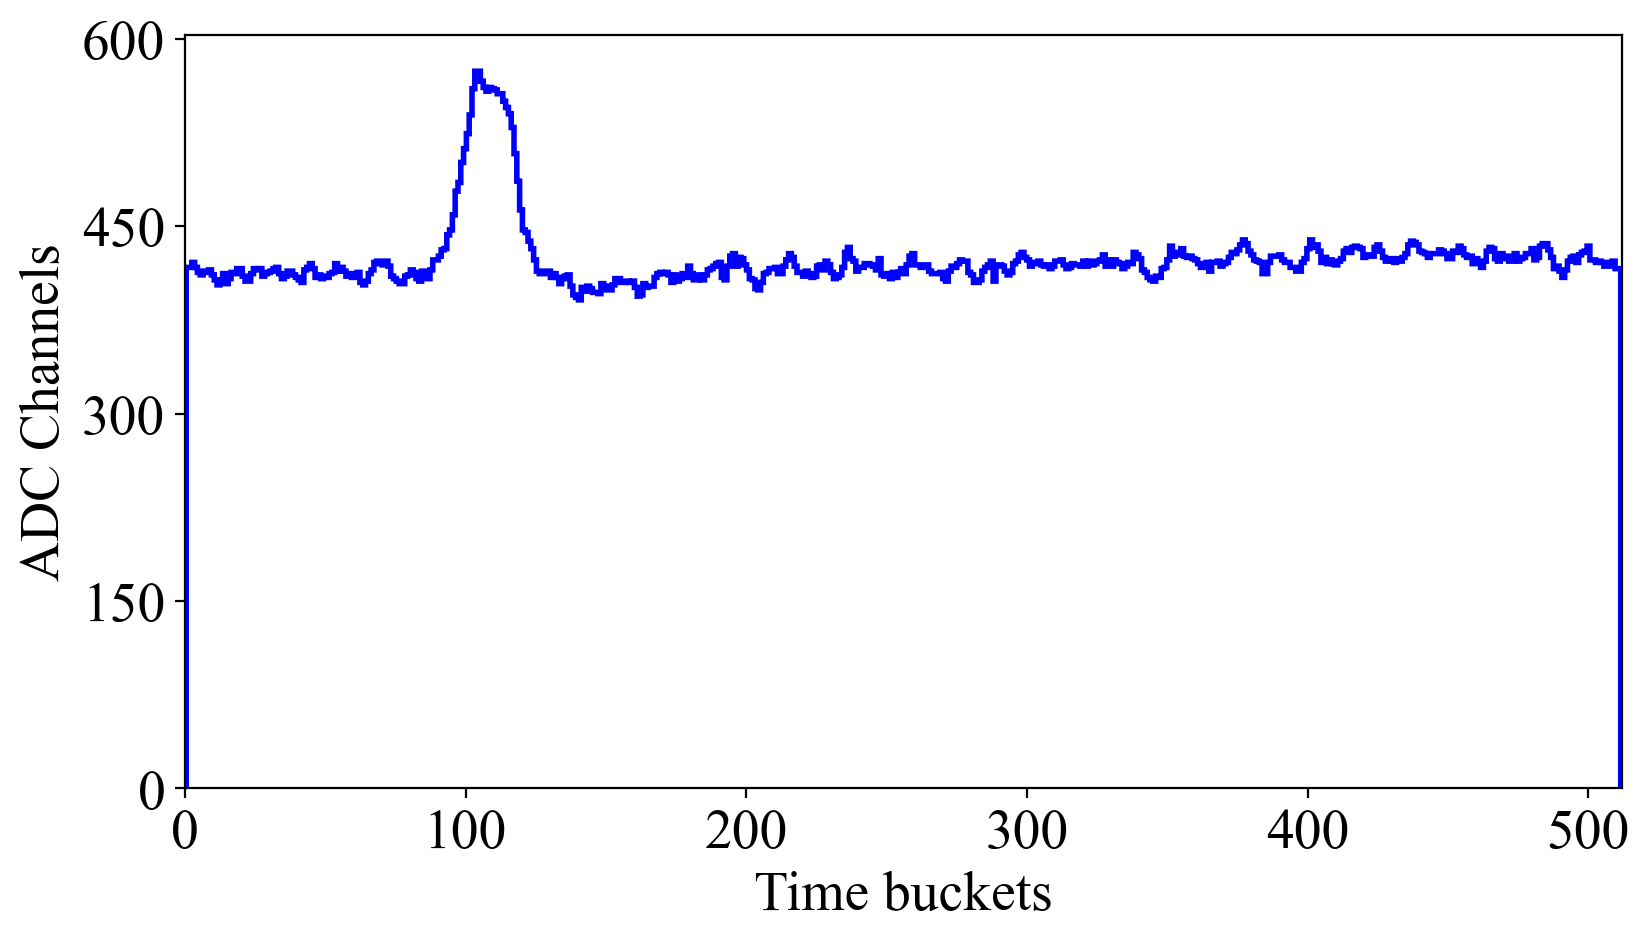

In [5]:
xt  = np.arange(0.5, 512, 1)
tam = 512
d = {152278 : 1, 165960 : 2}
# for num in [152278, 165960]:
# for num in [165960]:
num = 17424
# num = np.random.randint(low = 0, high = 100000, size = 1)[0]
print(num)
for num in [num]:
    print(f"Saída num = {num}")
    fig = plt.figure(dpi = 200, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step")
    # plt.plot(xt, y2[num], lw = 2, c = "green", label = "Resultado correto")
    # plt.plot(xt, predictions[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "Resultado do modelo")
    # plt.legend(fontsize = fonte, framealpha = 1., edgecolor = "black", loc = 2)
    # for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
    #     # label.set_fontproperties(font_prop)
    #     label.set_fontsize(fonte) # Size here overrides font_prop
    plt.tight_layout()
    # plt.xlabel("Buckets", fontsize = fonte)
    # plt.ylabel("ADC Charge", fontsize = fonte)
    plt.xlim(left = 0., right = 512.)
    plt.ylim(bottom = 0.)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(150))
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    # plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/apresentação/ex_sinal_{d[num]}.png", dpi = 600, bbox_inches='tight')
    # plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/apresentação/ex_sinal_{num}.png", dpi = 600, bbox_inches='tight')
    plt.show()

17424
Saída num = 17424


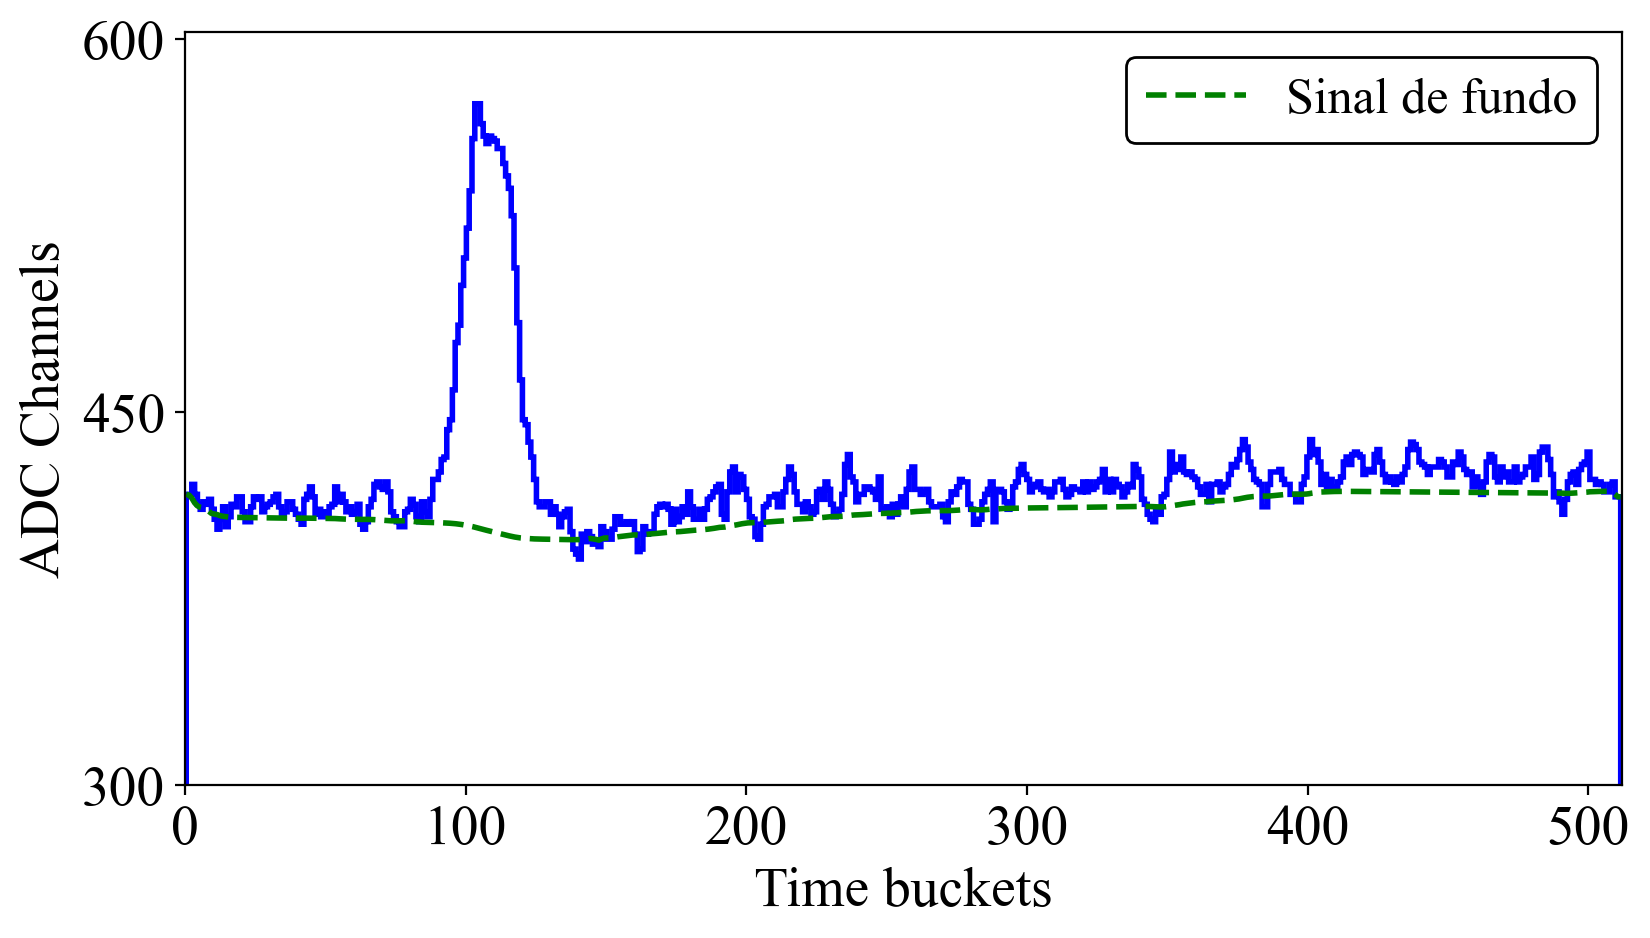

In [13]:
xt  = np.arange(0.5, 512, 1)
tam = 512
d = {152278 : 1, 165960 : 2}
# num = 35554
# num = 69430
num = 17424
fonte = 18
# for num in [152278, 165960]:
# for num in [165960]:
# number_peaks_list = np.array([len(a) for a in peaksDeconv], dtype = int)
# number_peak = 3
# nums = np.where(number_peaks_list == number_peak)[0]
# num = np.random.randint(low = 0, high = 100000, size = 1)[0]
# num = np.random.choice(nums, size = 1)[0]
print(num)
for num in [num]:
    print(f"Saída num = {num}")
    fig = plt.figure(dpi = 200, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step")
    plt.plot(xt, BKG[num], lw = 2, c = "green", label = "Sinal de fundo", ls = "--")
    # plt.plot(xt, y2[num], lw = 2, c = "green", label = "Resultado correto")
    # plt.plot(xt, predictions[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "Resultado do modelo")
    plt.legend(fontsize = fonte, framealpha = 1., edgecolor = "black", loc = 1)
    # for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
    #     # label.set_fontproperties(font_prop)
    #     label.set_fontsize(fonte) # Size here overrides font_prop
    plt.tight_layout()
    # plt.xlabel("Buckets", fontsize = fonte)
    # plt.ylabel("ADC Charge", fontsize = fonte)
    plt.xlim(left = 0., right = 512.)
    if num == 17424:
        plt.ylim(bottom = 300.)
    else:
        plt.ylim(bottom = 0., top = None)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(150))
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    # plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/apresentação/ex_sinal_{d[num]}.png", dpi = 600, bbox_inches='tight')
    plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/apresentação/ex_sinal_fundo_{num}.png", dpi = 600, bbox_inches='tight')
    plt.show()

17424
Saída num = 17424


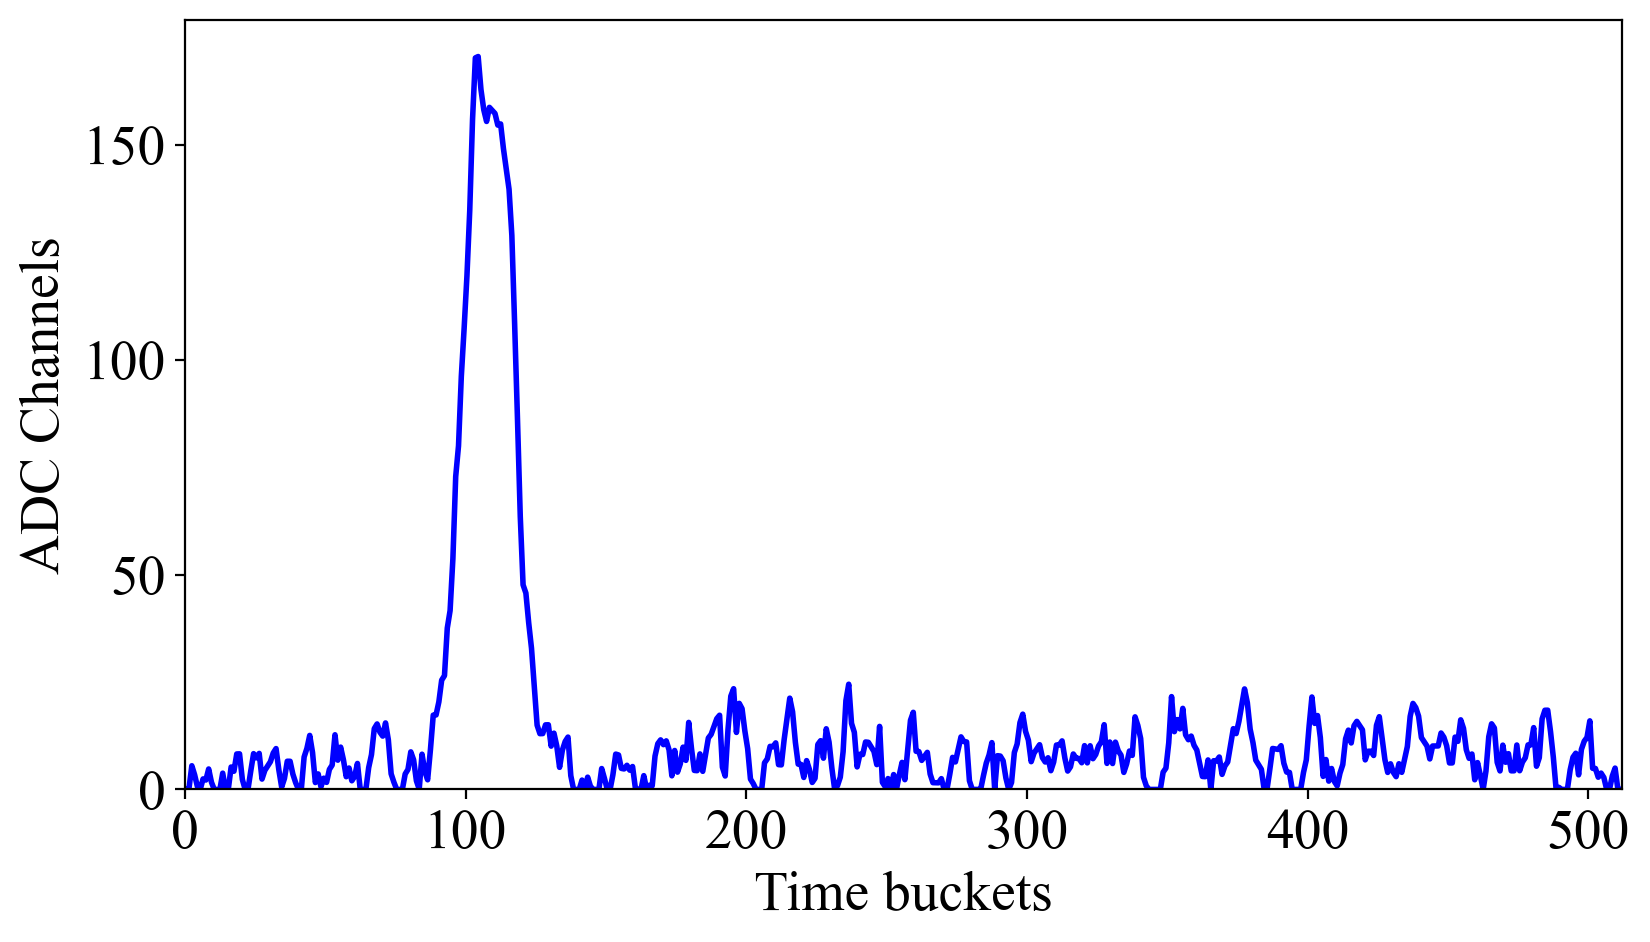

In [11]:
xt  = np.arange(0.5, 512, 1)
tam = 512
d = {152278 : 1, 165960 : 2}
# num = 69430
num = 17424
fonte = 16
# for num in [152278, 165960]:
# for num in [165960]:
# num = np.random.randint(low = 0, high = 100000, size = 1)[0]
print(num)
for num in [num]:
    print(f"Saída num = {num}")
    fig = plt.figure(dpi = 200, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    # plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step")
    # plt.plot(xt, BKG[num], lw = 2, c = "green", label = "Sinal de fundo", ls = "--")
    plt.plot(xt, y1[num], lw = 2, c = "blue")
    # plt.plot(xt, y2[num], lw = 2, c = "red", label = "Sinal após deconvolução", alpha = 0.75)
    # plt.plot(xt, predictions[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "Resultado do modelo")
    # plt.legend(fontsize = fonte, framealpha = 1., edgecolor = "black", loc = 2)
    # for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
    #     # label.set_fontproperties(font_prop)
    #     label.set_fontsize(fonte) # Size here overrides font_prop
    plt.tight_layout()
    # plt.xlabel("Buckets", fontsize = fonte)
    # plt.ylabel("ADC Charge", fontsize = fonte)
    plt.xlim(left = 0., right = 512.)
    if num == 17424:
        plt.ylim(bottom = 300.)
    else:
        plt.ylim(bottom = 0., top = None)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    # plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/apresentação/ex_sinal_{d[num]}.png", dpi = 600, bbox_inches='tight')
    plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/apresentação/ex_sinal_sem_fundo_{num}.png", dpi = 600, bbox_inches='tight')
    # plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/apresentação/ex_sinal_deconv_{num}.png", dpi = 600, bbox_inches='tight')
    plt.show()

Saída num = 165960


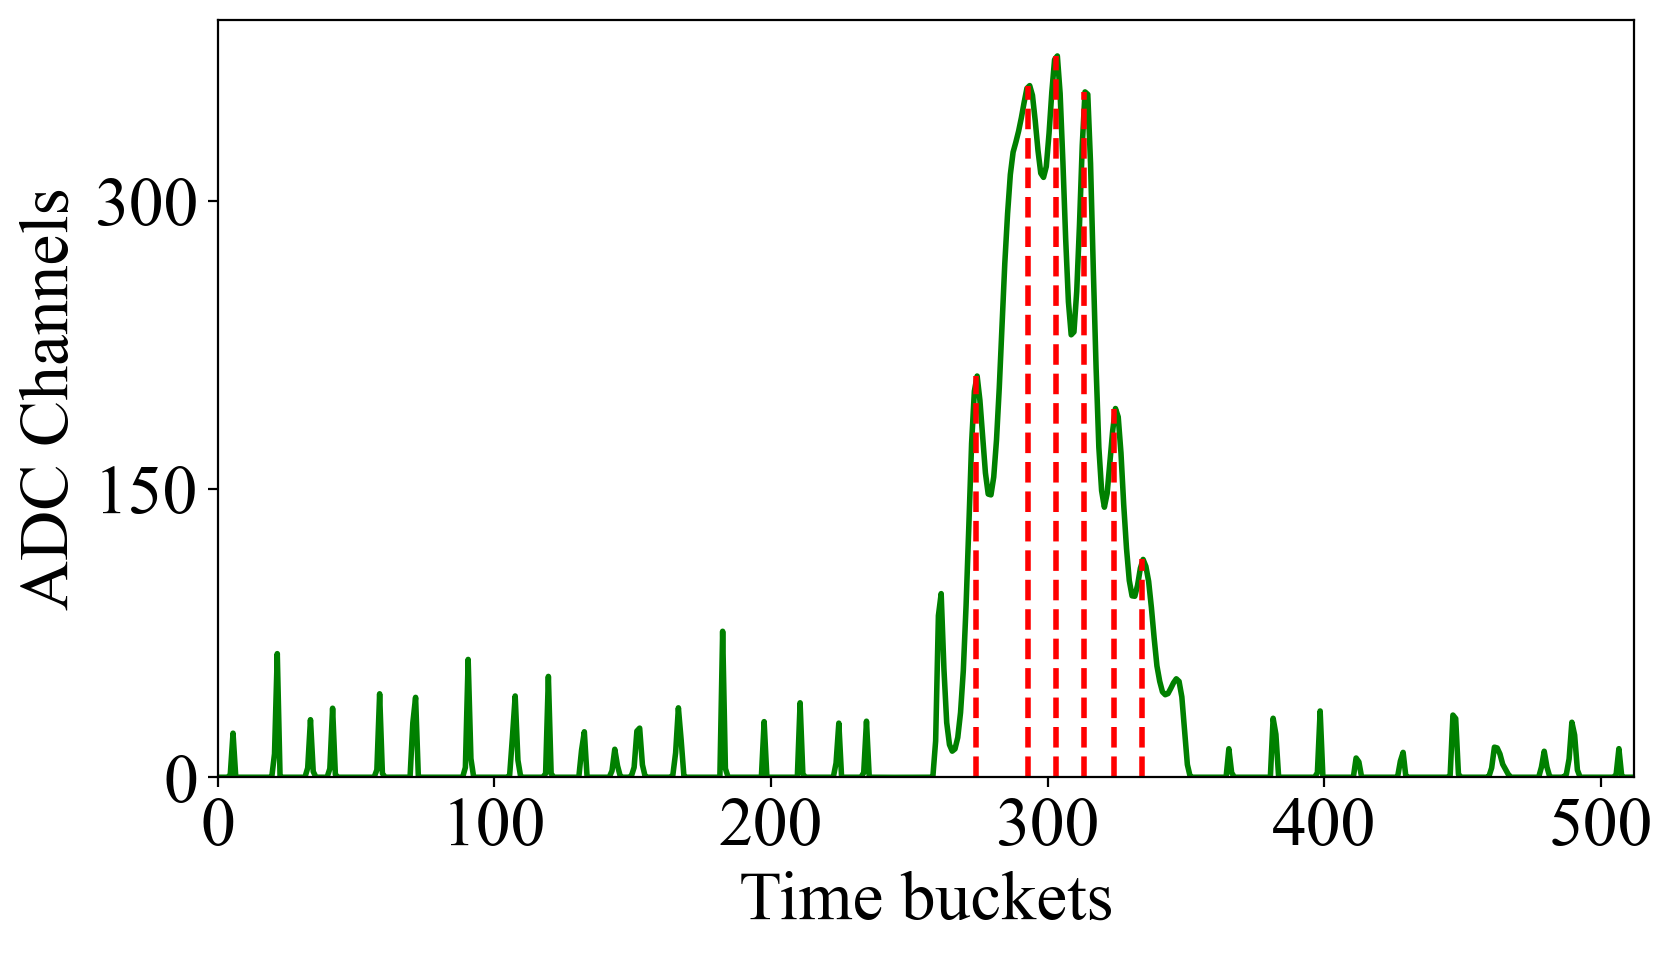

In [7]:
xt  = np.arange(0.5, 512, 1)
tam = 512
d = {152278 : 1, 165960 : 2}
# for num in [152278, 165960]:
for num in [165960]:
    print(f"Saída num = {num}")
    fig = plt.figure(dpi = 200, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    # plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step")
    plt.plot(xt, y2[num], lw = 2, c = "green", label = "Resultado correto")
    plt.vlines(peaksDeconv[num], 0, y2[num][peaksDeconv[num]], lw = 2, color = "red", ls = "--")
    # plt.plot(xt, predictions[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "Resultado do modelo")
    # plt.legend(fontsize = fonte, framealpha = 1., edgecolor = "black", loc = 2)
    # for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
    #     # label.set_fontproperties(font_prop)
    #     label.set_fontsize(fonte) # Size here overrides font_prop
    plt.tight_layout()
    # plt.xlabel("Buckets", fontsize = fonte)
    # plt.ylabel("ADC Charge", fontsize = fonte)
    plt.xlim(left = 0., right = 512.)
    plt.ylim(bottom = 0.)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(150))
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/apresentação/ex_sinal_deconv_{d[num]}.png", dpi = 600, bbox_inches='tight')
    plt.show()

## Saída um pico

In [ ]:
xt = np.arange(0.5, 512, 1)
fonte = 20
# num = np.random.randint(low = 0, high = len(predictions), size = 1)[0]
# num = next(gen)
d = {0 : "b", 2 : "a", 143 : "c", 148 : "d"}
num = 148
print(f"Saída num = {num}")
predict = predict_decv[num].reshape(-1)/0.85
picos_p = fp(predict, height = 50., distance = 4, prominence = 4)[0]
picos = []
for p in picos_p:
    if y1[num][p] > 50.:
        picos.append(p)
picos = np.array(picos, dtype = int)
fig = plt.figure(dpi = 200, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
# plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Raw signal")
# for pico in picos[np.array([0, 1, 3, 4, 5])]:
for pico in picos:
    extra = 4
    area = np.arange(pico - extra, pico + extra + 1)
    plt.fill_between(area, predict[area.astype(int)], alpha = 0.3, color = "#5B5936", label = "Integral")
    plt.plot(np.array([pico, pico], dtype = int), np.array([0., predict[pico]]), lw = 2., ls = "-.", c = "green",
             alpha = 0.75, label = "Detected centroid")
#     extra = 4
#     area = np.arange(pico - extra, pico + extra + 1)
#     plt.fill_between(area, predict[area.astype(int)], alpha = 0.3, color = "#5B5936", label = "Integral")

plt.plot(xt, predict, lw = 2, ls = "--", c = "red", label = "CNN")
plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Raw signal w/o baseline", alpha = 0.75)
# plt.plot(xt, BKG[num], lw = 2, c = "green", label = "Correto")
# plt.plot(xt, predict_bkg[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "CNN")
# plt.axhline(y = 50., ls = "--", lw = 2., c = "black", zorder = 0, label = "Threshold")
# plt.legend(fontsize = fonte - 3, framealpha = 1., edgecolor = "black", loc = 2)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
print(list(by_label.keys()))
nomes_1 = list(by_label.keys())
lines_1 = list(by_label.values())
nomes = [nomes_1[2], nomes_1[-1], nomes_1[1], nomes_1[0]]
lines = [lines_1[2], lines_1[-1], lines_1[1], lines_1[0]]
# plt.legend(lines, nomes, fontsize = fonte - 3.5, framealpha = 1., edgecolor = "black", loc = 2)
plt.tight_layout()
plt.xlabel("Time buckets", fontsize = fonte)
plt.ylabel("ADC Channels", fontsize = fonte)
# plt.title(num)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
fig.gca().set_ylim(bottom = 0)
# fig.gca().set_ylim(bottom = 0, top = 900)
fig.gca().set_xlim(left = 200, right = 500)
bottom, top = plt.ylim()
plt.text(485, (top-bottom)*0.9, d[num], fontsize = 28, weight='bold')
plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/apresentação/ex_sinal_peaks_{num}.png", dpi = 600, bbox_inches='tight')
plt.show()

## Animation deconvolution

In [6]:
import tpc_utils as tpc

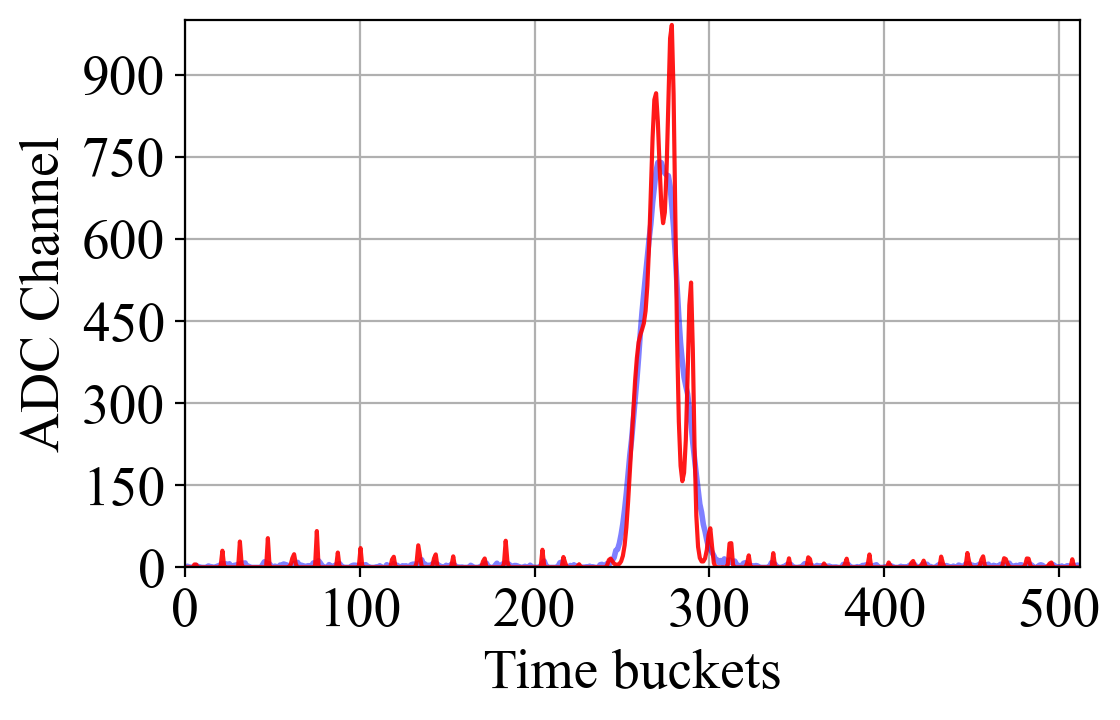

In [24]:
# fig, ax = plt.subplots(dpi = 200, figsize = (12, 4))
fig, ax = plt.subplots(dpi = 200)
fig.set_facecolor('white')
ax.set_ylim(0, 1000)
ax.set_xlim(0, 512)
ax.set(xlabel = "Time buckets", ylabel = "ADC Channel")
ax.grid(True)
num = 69430
# x        = np.arange(0.5, 512, 1)
data_raw = y1[num]
data     = np.array(
    [tpc.search_high_res(signal=data_raw,
     sigma = 4.3,
     threshold=20,
     remove_bkg=False,
     number_it=i,
     markov = False,
     aver_window=3)[0]
     for i in range(701)],
     dtype = float
    )
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(150))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(100))
line1, = ax.plot(xt, data_raw, lw = 2, c = 'b', alpha = 0.5) # [line1]
line2, = ax.plot(xt, data_raw, lw = 1.5, c = 'r', alpha = 0.9)
plt.tight_layout()

def animate(i):
    line1.set_ydata(data_raw)  # update the data.
    line2.set_ydata(data[i])
    return line1, line2,

ani = animation.FuncAnimation(
    fig, animate, frames=700, interval=150)

writergif = animation.PillowWriter(fps=30)
FFwriter = animation.FFMpegWriter(fps = 60)
# ani.save("deconv.mp4", writer = FFwriter)
ani.save("deconv.gif", writer = writergif)

plt.show()


## Resultados CNN

Saída num = 17424


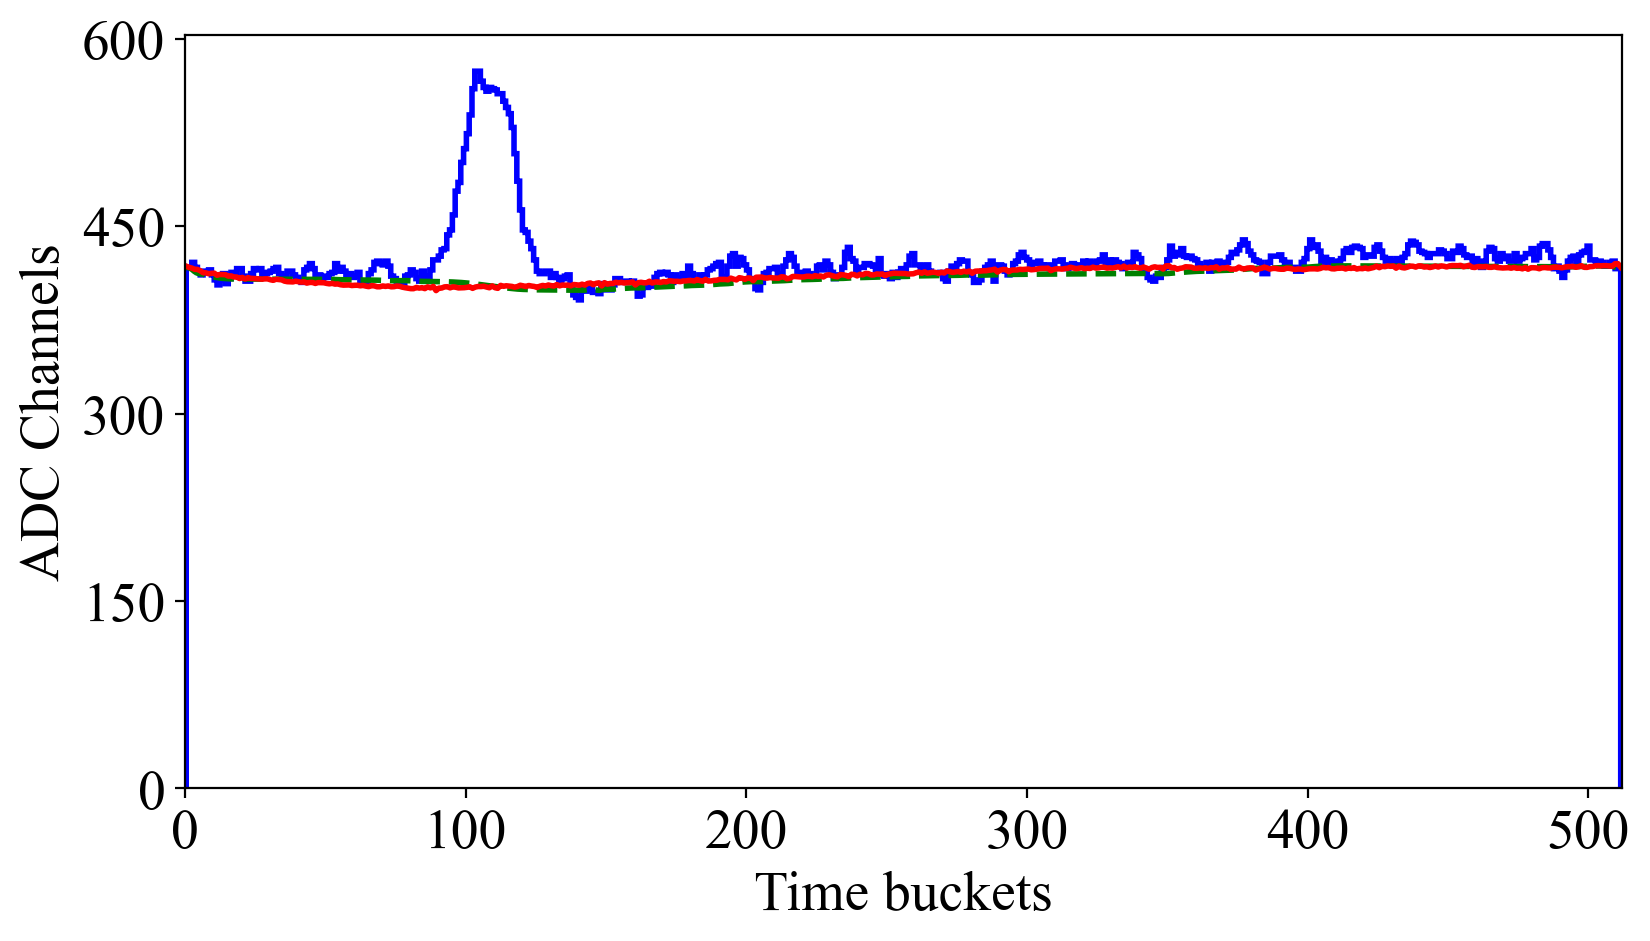

In [4]:
xt  = np.arange(0.5, 512, 1)
tam = 512
# d = {152278 : 1, 165960 : 2}
# for num in [152278, 165960]:
num = np.random.randint(0, len(y1), size = 1)[0]
# for num in [165960]:
print(f"Saída num = {num}")
fig = plt.figure(dpi = 200, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue",
 histtype = "step", label = "Sinal")
# plt.plot(xt, x1[num], lw = 2, c = "green", label = "Sinal")
plt.plot(xt, BKG[num].reshape(-1), lw = 2, ls = "--", c = "green", label = "Fundo")
plt.plot(xt, bkg_predict[num].reshape(-1), lw = 2, ls = "-", c = "red", label = "Fundo CNN")
# plt.vlines(peaksDeconv[num], 0, y2[num][peaksDeconv[num]], lw = 2, color = "red", ls = "--")
# plt.vlines(peaksDeconv[num], 0, y2[num][peaksDeconv[num]], lw = 2, color = "red", ls = "--")
# plt.legend(fontsize = fonte, framealpha = 1., edgecolor = "black", loc = 2)
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte) # Size here overrides font_prop
plt.tight_layout()
# plt.xlabel("Buckets", fontsize = fonte)
# plt.ylabel("ADC Charge", fontsize = fonte)
plt.xlim(left = 0., right = 512.)
plt.ylim(bottom = 0.)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(150))
plt.xlabel("Time buckets")
plt.ylabel("ADC Channels")
# plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/apresentação/ex_sinal_fundo_{num}.png", dpi = 600, bbox_inches='tight')
plt.show()

### fit

In [5]:
class H():

    def __init__(self, *filtros, **kargs):
        print(filtros)
        print(kargs)
        self.filtros = filtros
        self.kargs = kargs

    def apply(self, x):
        apps = [filtro(x) for filtro in self.filtros]
        return all(apps)
    
a = H(lambda x: x > 0, lambda x: x < 10, lambda x: x != 5, a = 5, b = 10)

print(a.apply(12))

(<function <lambda> at 0x000001B736188E50>, <function <lambda> at 0x000001B7383C4670>, <function <lambda> at 0x000001B7383C6560>)
{'a': 5, 'b': 10}
False
